`transformer_experimentation.ipynb` did not succeed in learning even a linear function.
This is why here a simple general transformer example is adapted to work on time-series data as in Wu et. al.

# Prelude

In [1]:
import sys
import pathlib as pl
sys.path.insert(0,str(pl.Path("../").absolute()))

In [33]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn # neuronal layers, function objects
import torch.nn.functional as F # contains activation functions
from torch.autograd import Variable # wrapper for tensor
import torch.optim as opt
import numpy as np
import sklearn.preprocessing as skp
from utils.data_loader import load_data
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
from dataclasses import dataclass, asdict
from typing import *
import datetime
import copy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda


## helpers


In [78]:

def wrapBatch(data):
    data = data
    shape = list(data.shape)
    shape.insert(1,1)
    return np.reshape(data, shape)

def get_mask(dim1: int, dim2: int) -> torch.Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Modified from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html

    Args:

        dim1: int, for both src and tgt masking, this must be target sequence
              length

        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 


    Return:

        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1).to(device)


## Define Transformer

define encoder

In [6]:
# adapted from https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term) # TODO: why does this crash when d_model = 3?
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

class Encoder(nn.Module):
    def __init__(self, d_input, d_model, nhead=1):
        super(Encoder, self).__init__()

        # define layers (layers are functions)
        self.input_layer = nn.Linear(d_input, d_model) # input layer, 10 features in, 10 features out (== keras dense)
        self.pos_encoding_layer = PositionalEncoding(d_model,dropout=0.2)
        self.encoder_layers = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.2), num_layers=4) # stacks multiple encoder layers, contains self attention and feed forward with normalization in between, TODO: how many heads?

    # forward pass data x through network
    def forward(self, x: torch.Tensor):
        x = self.input_layer(x)
        x = self.pos_encoding_layer(x)
        x = self.encoder_layers(x)
        return x[0] # we ignore batching here, expected shape of x: [batch][pos in seq][dim]

define decoder

In [7]:

class Decoder(nn.Module):
    def __init__(self, d_input, d_model, nhead=1):
        super(Decoder, self).__init__()

        # define layers (layers are functions)
        self.input_layer = nn.Linear(d_input, d_model) # input layer, 10 features in, 10 features out (== keras dense)
        self.decoder_layers = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dropout=0.2), num_layers=4)
        self.linear_mapping = nn.Linear(
            in_features=d_model, 
            out_features=d_input
            )


    # forward pass data x through network
    def forward(self, x: torch.Tensor, memory: torch.Tensor, mask: torch.Tensor): #NOTE: TODO: implement Masking
        x = self.input_layer(x)
        x = self.decoder_layers(x,memory=memory,tgt_mask=mask)
        x = self.linear_mapping(x)
        return x
    

In [8]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_input, d_model,nhead=8):
        super(TimeSeriesTransformer, self).__init__()

        # define layers
        self.encoder = Encoder(d_input, d_model,nhead=nhead)
        self.decoder = Decoder(d_input, d_model,nhead=nhead)

        self.memory = None

    def encode(self, src: torch.Tensor):
        encoding = self.encoder(src)
        self.memory = encoding

    def forward(self, target: torch.Tensor, mask: torch.Tensor):
        if self.memory == None:
            raise ValueError("you need to call encode() first")
        out = self.decoder(x=target,memory=self.memory, mask=mask)
        return out

generate fake data (linear)

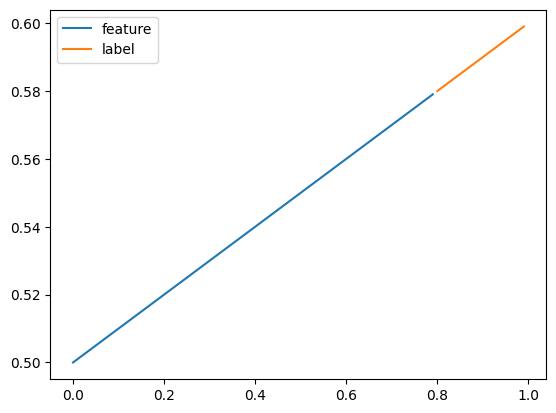

In [9]:
a = 0.1
b = 0.5
data_x = np.arange(0,1,0.01)
data_y = [a*y+b for y in data_x]

# split "window" into feature and label as in Wu et al
rel = 0.8
feature = data_y[:int(rel*len(data_y))]
label = data_y[int(rel*len(data_y)):]
plt.plot(data_x[:int(rel*len(data_y))],feature, label="feature")
plt.plot(data_x[int(rel*len(data_y)):],label, label="label")
plt.legend()

In [10]:
feature = torch.Tensor(feature).to(device)
label = torch.Tensor(label).to(device)

Network Training

In [11]:
#%%
d_input = 1
d_model = 2
nhead = 2
net = TimeSeriesTransformer(d_input, d_model,nhead=nhead)
net.to(device)
net.train(True)
#learning_rate = 2.8*(10**(-6)) # TODO: how is learning schedule implemented by Wu et al?
learning_rate = 0.01
print(f"learning rate {learning_rate}")
optimizer = opt.Adam(net.parameters(), lr=learning_rate,betas=[0.9,0.98], eps=10**(-9))
criterion = nn.MSELoss()
num_epochs = 500

#%%
losses = []
lr_updated = False
# go through every datapoint (1)
for i in range(num_epochs):
    # apply gradient to each epoch
    net.zero_grad()
    optimizer.zero_grad()
    
    net.encode(torch.unsqueeze(feature,0).T)

    predicted_labels = []
    # we start with last feature label as input(do not use in loss)
    # last label does not get used for input only for error lost
    target_labels = [feature[-1]] + list(label) 
    # train every step in window individually
    for sp in range(len(target_labels)-1):
        decoder_input = target_labels[:sp+1]
        decoder_input = torch.Tensor(decoder_input).to(device)
        decoder_input = torch.unsqueeze(decoder_input,0)
        #decoder_input = torch.unsqueeze(decoder_input,0)
        decoder_input = decoder_input.T
        out = net.forward(decoder_input,None) #TODO: add Masking
        newly_predicted = out[-1] # always only one new because of shifted label prediction
        predicted_labels.append(newly_predicted) 
        
    # first label was only to feed input
    y_label = torch.tensor(target_labels[1:]).to(device)
    y_predicted = torch.squeeze(torch.stack(predicted_labels))
    #print(y_label.shape, y_predicted)
    loss = criterion(y_label, y_predicted)
    loss.backward()
    optimizer.step()
    if i > 250 and lr_updated == False:
        optimizer.param_groups[0]['lr'] = 0.0000001 #1e-7
        lr_updated = True
        print(f"new learning rate {optimizer.param_groups[0]['lr']}")
    if i % 10 == 0: print(f"{i}: loss={loss}")

#%%
# example result of trained net and conversion to numpy
#x_numpy = np.array([1,0,0,0,1,0,0,0,1,1])
#x = torch.Tensor(x_numpy).to(net.device)
#y = net(x)
#y_numpy = y.detach().cpu().numpy()
#print("in  ", x_numpy.astype(np.int8))
#print("out ", np.abs(np.rint(y_numpy)).astype(np.int8)) # as nearest (positive) int
# %% 

learning rate 0.01
0: loss=0.03986319899559021
10: loss=0.006263058166950941
20: loss=0.0006907698116265237
30: loss=3.3615764550631866e-05
40: loss=0.00016705517191439867
50: loss=3.37504425260704e-05
60: loss=3.327232843730599e-05
70: loss=3.329186074552126e-05
80: loss=3.331017796881497e-05
90: loss=3.3251541026402265e-05
100: loss=3.3257834729738533e-05
110: loss=3.325003126519732e-05
120: loss=3.325064244563691e-05
130: loss=3.325060606584884e-05
140: loss=3.3250016713282093e-05
150: loss=3.325015495647676e-05
160: loss=3.3250114938709885e-05
170: loss=3.324997305753641e-05
180: loss=3.3250165870413184e-05
190: loss=3.325006764498539e-05
200: loss=3.325005673104897e-05
210: loss=3.325009674881585e-05
220: loss=3.324984209029935e-05
230: loss=3.3250216802116483e-05
240: loss=3.324983481434174e-05
250: loss=3.3250125852646306e-05
new learning rate 1e-07
260: loss=3.324990757391788e-05
270: loss=3.3249925763811916e-05
280: loss=3.3250002161366865e-05
290: loss=3.324993667774834e-05
3

In [16]:
net.encode(torch.unsqueeze(feature,0).T)
res = torch.Tensor(torch.unsqueeze(label,0).T).to(device)
out = net(res,None)
out

tensor([[0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895],
        [0.5895]], device='cuda:0', grad_fn=<AddmmBackward0>)

it seems that at least something is learned here

In [13]:
label

tensor([0.5800, 0.5810, 0.5820, 0.5830, 0.5840, 0.5850, 0.5860, 0.5870, 0.5880,
        0.5890, 0.5900, 0.5910, 0.5920, 0.5930, 0.5940, 0.5950, 0.5960, 0.5970,
        0.5980, 0.5990], device='cuda:0')

In [14]:
np.var(label.cpu().detach().numpy())

3.325002e-05

In [15]:
np.var(out.cpu().detach().numpy())

1.6342483e-14

# Try with real data

In [17]:
data_temp, data_wind = load_data()
display(data_temp.head(3))
display(data_wind.head(3))

,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:42,526487,467544,442
1,2022-01-22 13:53:44,526542,467315,461
2,2022-01-22 13:53:45,526532,466868,466


,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:37,505940,507749,621
1,2022-01-22 13:53:38,505846,507807,632
2,2022-01-22 13:53:40,505990,507764,629


In [23]:
def scale_and_resample_timeindex(df: pd.DataFrame, timefreq="10s", aggregator="mean"):
    df = df.set_index("timestamp")
    df = df[~df.index.duplicated(keep="first")]
    df = df.resample(timefreq).aggregate(aggregator)
    scaler = skp.MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df), index=df.index, columns=df.columns)
    return df, scaler

In [27]:
data = data_temp.copy().iloc[:1000,:]
timefreq="5s"
aggregator="mean"
window_size=12
feature_size=10

def get_window(data, i, wsize):
    window = data.iloc[i:i+wsize, 1:].to_numpy()
    timestamps = data.iloc[i:i+wsize, 0].to_numpy()
    isvalid = not np.any(np.isnan(window))
    if window.shape[0] != wsize:
        isvalid = False
    return window, timestamps, isvalid

def get_datapoint(data, i, wsize, fsize):
    window, timestamps, isvalid = get_window(data, i, wsize)
    feature, label = window[0:fsize,:], window[fsize:,:]
    return feature, label, timestamps, isvalid

def get_valid_windows(data, wsize):
    valid_indexes = []
    print("computing valid windows")
    for i in tqdm(range(data.shape[0])):
        _,_, isvalid = get_window(data,i,wsize)
        if isvalid:
            valid_indexes.append(i)
    print(f"found {len(valid_indexes)} valid window(s)")
    return valid_indexes

data_resampled, scaler = scale_and_resample_timeindex(data, timefreq=timefreq, aggregator=aggregator)
data_resampled = data_resampled[["differential_potential_CH1"]]
data_resampled = data_resampled.reset_index()
valid_windows = get_valid_windows(data_resampled, window_size)
window, timestamps, isvalid = get_window(data_resampled, valid_windows[0],window_size)
feature, label, timestamps, isvalid = get_datapoint(data_resampled, valid_windows[0], window_size, feature_size)

computing valid windows


100%|██████████| 348/348 [00:00<00:00, 4970.33it/s]

found 337 valid window(s)


In [79]:
@dataclass(frozen=True,slots=True)
class ExperimentData:
    data_resampled: pd.DataFrame
    scaler: skp.MinMaxScaler
    timefreq: str
    aggregator: str|Callable
    columns: list[str]
    window_size: int
    feature_size: int
    valid_windows: list[int]

@dataclass(frozen=True, slots=True)
class TrainingData:
    net: TimeSeriesTransformer
    d_input: int
    d_model: int
    n_head: int
    seed: int|None
    learning_rate: float
    epochs: float
    losses: list[float]
    best_loss: float|None
    best_net: None|TimeSeriesTransformer


def getExperimentData(data, timefreq, aggregator, columns, window_size, feature_size):
    data_resampled, scaler = scale_and_resample_timeindex(data, timefreq=timefreq, aggregator=aggregator)
    data_resampled = data_resampled[columns]
    data_resampled = data_resampled.reset_index()
    valid_windows = get_valid_windows(data_resampled, window_size)
    #feature, label, timestamps, isvalid = get_datapoint(data_resampled, valid_windows[0], window_size, feature_size) 
    return ExperimentData(data_resampled, scaler, timefreq, aggregator, columns, window_size, feature_size, valid_windows)

def trainExperiment(data: ExperimentData, d_model, nhead, learning_rate, num_epochs, seed):
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
    #%%
    d_input = len(data.columns)
    net = TimeSeriesTransformer(d_input, d_model,nhead=nhead)
    net.to(device)
    net.train(True)
    #learning_rate = 2.8*(10**(-6)) # TODO: how is learning schedule implemented by Wu et al?
    learning_rate = 0.0001
    print(f"using learning rate {learning_rate}")
    optimizer = opt.Adam(net.parameters(), lr=learning_rate,betas=[0.9,0.98], eps=10**(-9))
    criterion = nn.MSELoss()

    #%%
    losses = []
    lr_updated = False
    lr_updated_2 = False
    best_loss = float('inf')
    best_net = None
    # go through every datapoint (1)
    for i in range(num_epochs):
        # apply gradient to each epoch
        net.zero_grad()
        optimizer.zero_grad()

        window_index = data.valid_windows[int(np.random.uniform(0,len(data.valid_windows)))]
        feature, label, _timestamps, _isvalid = get_datapoint(data.data_resampled, window_index,data.window_size,data.feature_size) 
        feature = torch.Tensor(feature).to(device)
        label = torch.Tensor(label).to(device)
        #print(feature.shape, label.shape)
                
        net.encode(torch.unsqueeze(feature,0).T)
        
        predicted_labels = []
        # we start with last feature label as input(do not use in loss)
        # last label does not get used for input only for error lost
        target_labels = [feature[-1]] + list(label) 
        # train every step in window individually
        for sp in range(len(target_labels)-1):
            decoder_input = target_labels[:sp+1]
            decoder_input = torch.Tensor(decoder_input).to(device)
            decoder_input = torch.unsqueeze(decoder_input,0)
            #decoder_input = torch.unsqueeze(decoder_input,0)
            decoder_input = decoder_input.T
            out = net.forward(decoder_input,get_mask(decoder_input.shape[0],decoder_input.shape[0])) #TODO: add masking
            newly_predicted = out[-1] # always only one new because of shifted label prediction
            predicted_labels.append(newly_predicted) 
            
        # first label was only to feed input
        y_label = torch.tensor(target_labels[1:]).to(device)
        y_predicted = torch.squeeze(torch.stack(predicted_labels))
        #print(y_label.shape, y_predicted)
        loss = criterion(y_label, y_predicted)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().detach().numpy())
        if i > 2500 and lr_updated == False:
            optimizer.param_groups[0]['lr'] = 0.0000001 #1e-7
            lr_updated = True
            print(f"new learning rate {optimizer.param_groups[0]['lr']}")
        if i > 5000 and lr_updated_2 == False:
            optimizer.param_groups[0]['lr'] = 0.0000000001 #1e-10
            lr_updated_2 = True
            print(f"new learning rate {optimizer.param_groups[0]['lr']}")
        if i % 100 == 0: print(f"{i}: avg_loss={np.mean(loss)}")
        if loss < best_loss:
            best_loss = loss
            model_clone = TimeSeriesTransformer(d_input, d_model,nhead)
            model_clone.load_state_dict(copy.deepcopy(net.state_dict()))
            best_net = copy.deepcopy(model_clone) # deepcopy should retain weights
    return TrainingData(net, d_input, d_model,nhead, seed, learning_rate, num_epochs, losses, best_loss.cpu().detach().numpy(), best_net)

expData = getExperimentData(
    data_temp.copy().iloc[:1000,:],
    timefreq="5s",
    aggregator="mean",
    columns=["transpiration"],
    window_size=12,
    feature_size=10)

trainData = trainExperiment(expData, 16,16, 0.001, 10000, 0)


computing valid windows


100%|██████████| 348/348 [00:00<00:00, 5437.55it/s]

found 337 valid window(s)
using learning rate 0.0001
0: loss=0.1176532432436943


100: loss=0.003992353565990925
200: loss=0.11094772070646286
300: loss=0.008678494021296501
400: loss=0.021544525399804115
500: loss=0.008774396032094955
600: loss=0.09015243500471115
700: loss=0.018066437914967537
800: loss=0.02497927099466324
900: loss=0.0001602868433110416
1000: loss=0.020441392436623573
1100: loss=0.04285673424601555
1200: loss=0.015176264569163322
1300: loss=0.0684320405125618
1400: loss=0.019809585064649582
1500: loss=0.003225088817998767
1600: loss=0.013287200592458248
1700: loss=0.005008825566619635
1800: loss=0.002205678727477789
1900: loss=0.004036694765090942
2000: loss=0.011947107501327991
2100: loss=0.0019543753005564213
2200: loss=0.0018416640814393759
2300: loss=0.0032817290630191565
2400: loss=0.023562604561448097
2500: loss=0.009176129475235939
new learning rate 1e-07
2600: loss=0.00219483720138669
2700: loss=0.00035522785037755966
2800: loss=0.0016114194877445698
2900: loss=0.05891571193933487
3000: loss=0.023439325392246246
3100: loss=0.0213535502552

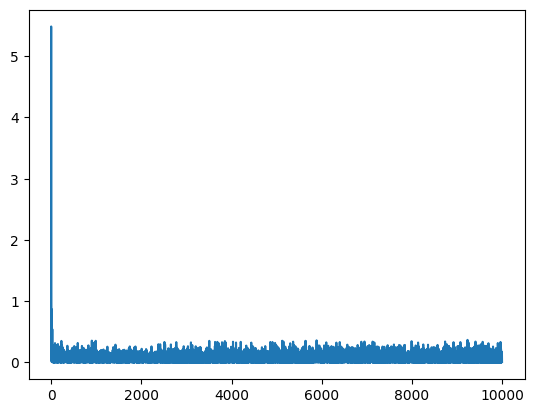

In [45]:
plt.plot([l.cpu().detach().numpy() for l in trainData.losses], label="loss")
plt.plot([np.mean(trainData.losses[:i]) for i in range(len(trainData.losses))], label="avg_losses")
plt.legend()

In [72]:
#window_index = data.valid_windows[int(np.random.uniform(0,len(data.valid_windows)))]
window_index = expData.valid_windows[100] # any
feature, label, _timestamps, _isvalid = get_datapoint(expData.data_resampled, window_index,expData.window_size,expData.feature_size) 
feature = torch.Tensor(feature).to(device)
label = torch.Tensor(label).to(device)
decoder_input = feature[-2:]
net = trainData.best_net
net.to(device)
net.encode(torch.unsqueeze(feature,0).T)
out = net(decoder_input,mask=None)
out

tensor([[0.3781],
        [0.4058]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [73]:
nn.MSELoss()(out,label[:2])

tensor(0.1067, device='cuda:0', grad_fn=<MseLossBackward0>)